# Loan Approval EDA — Built on Cleaned Data

This notebook performs a focused exploratory data analysis (EDA) using the cleaned dataset produced in `01_data_cleaning.ipynb`. It reuses the same feature engineering so plots and stats reflect the exact features used downstream.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme(style='whitegrid', context='notebook')
pd.set_option('display.max_columns', 100)
DATA_DIR = Path('..') / 'data'
FIG_DIR = Path('..') / 'reports' / 'figures'
FIG_DIR.mkdir(parents=True, exist_ok=True)

RAW_TRAIN = DATA_DIR / 'train.csv'
TRAIN_CLEAN = DATA_DIR / 'train_cleaned.csv'
TEST_CLEAN = DATA_DIR / 'test_cleaned.csv'
RAW_TRAIN.exists(), TRAIN_CLEAN.exists(), TEST_CLEAN.exists()


(True, True, True)

## Load Data
- Load raw and cleaned train data.
- Combine: keep raw categoricals for readable plots; append engineered features from the cleaned file.

In [2]:
df_raw = pd.read_csv(RAW_TRAIN)
df_clean = pd.read_csv(TRAIN_CLEAN)
print(f'Loaded raw: {RAW_TRAIN} shape={df_raw.shape}')
print(f'Loaded clean: {TRAIN_CLEAN} shape={df_clean.shape}')

assert len(df_raw) == len(df_clean), 'Row count mismatch between raw and cleaned'

# Build analysis frame: start from raw (for readable categoricals), drop id, add engineered features
df = df_raw.copy()
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# Add columns present only in cleaned
for col in df_clean.columns:
    if col not in df.columns:
        df[col] = df_clean[col]

print('Final EDA frame shape:', df.shape)
df.head(3)


Loaded raw: ..\data\train.csv shape=(58645, 13)
Loaded clean: ..\data\train_cleaned.csv shape=(58645, 26)
Final EDA frame shape: (58645, 29)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,cb_person_default_on_file_bin,dti,cred_hist_per_age,age_emp_interaction,risk_factor,high_income,short_emp,young_borrower,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_encoded
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0,0,0.171429,0.378378,0.0,68940.0,0,1,0,False,False,True,True,False,False,False,False,2
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0,0,0.071429,0.090909,132.0,53400.0,0,0,1,False,True,False,False,False,True,False,False,3
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0,0,0.208333,0.344828,232.0,53400.0,0,0,0,False,True,False,False,False,False,True,False,1


## Reconstruct Encoded Categoricals
For group plots, recreate readable categories from one-hot columns (which were created with `drop_first=True`).
- `person_home_ownership`: baseline assumed to be `MORTGAGE` since dummies include `OTHER`, `OWN`, `RENT`.
- `loan_intent`: baseline assumed to be `DEBTCONSOLIDATION` given common dataset variants.

In [3]:
# Reconstruct home ownership
home_dummy_prefix = 'person_home_ownership_'
home_cats = ['OTHER','OWN','RENT']
def _home_cat(row):
    for c in home_cats:
        if row.get(f'{home_dummy_prefix}{c}', False) in (1, True):
            return c
    return 'MORTGAGE'

df['home_ownership_rec'] = df.apply(_home_cat, axis=1)

# Reconstruct loan intent
intent_dummy_prefix = 'loan_intent_'
intent_cats = ['EDUCATION','HOMEIMPROVEMENT','MEDICAL','PERSONAL','VENTURE']
def _intent_cat(row):
    for c in intent_cats:
        if row.get(f'{intent_dummy_prefix}{c}', False) in (1, True):
            return c
    return 'DEBTCONSOLIDATION'

df['loan_intent_rec'] = df.apply(_intent_cat, axis=1)

df[['person_home_ownership','home_ownership_rec','loan_intent','loan_intent_rec']].head(5)


,person_home_ownership,home_ownership_rec,loan_intent,loan_intent_rec
0,RENT,RENT,EDUCATION,EDUCATION
1,OWN,OWN,MEDICAL,MEDICAL
2,OWN,OWN,PERSONAL,PERSONAL
3,RENT,RENT,VENTURE,VENTURE
4,RENT,RENT,MEDICAL,MEDICAL


## Overview
- Shape and target distribution
- Missing values
- Numeric summary

Shape: (58645, 31)
Columns: 31
Target value counts:
loan_status
No Default    50295
Default        8350
Name: count, dtype: int64


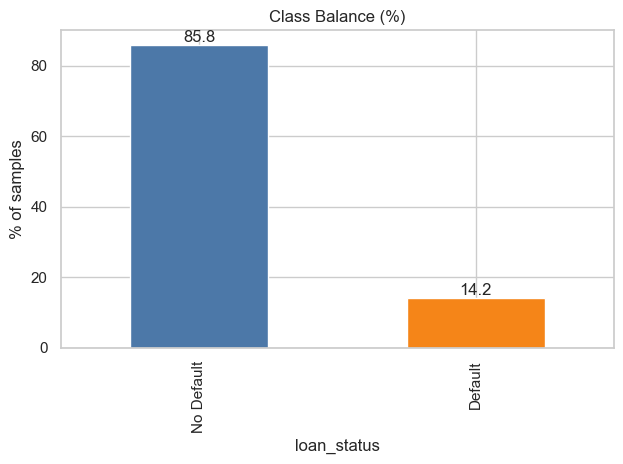

Missing values (top 20):


Series([], dtype: int64)

,count,mean,std,min,25%,50%,75%,max
person_age,58645.0,27.550857,6.033216,20.000000,23.000000,26.000000,30.000000,1.230000e+02
person_income,58645.0,64046.172871,37931.106978,4200.000000,42000.000000,58000.000000,75600.000000,1.900000e+06
person_emp_length,58645.0,4.701015,3.959784,0.000000,2.000000,4.000000,7.000000,1.230000e+02
loan_amnt,58645.0,9217.556518,5563.807384,500.000000,5000.000000,8000.000000,12000.000000,3.500000e+04
loan_int_rate,58645.0,10.677874,3.034697,5.420000,7.880000,10.750000,12.990000,2.322000e+01
loan_percent_income,58645.0,0.159238,0.091692,0.000000,0.090000,0.140000,0.210000,8.300000e-01
cb_person_cred_hist_length,58645.0,5.813556,4.029196,2.000000,3.000000,4.000000,8.000000,3.000000e+01
loan_status,58645.0,0.142382,0.349445,0.000000,0.000000,0.000000,0.000000,1.000000e+00
cb_person_default_on_file_bin,58645.0,0.148384,0.355484,0.000000,0.000000,0.000000,0.000000,1.000000e+00
dti,58645.0,0.159774,0.094263,0.000789,0.089286,0.142276,0.209302,3.125000e+00


In [6]:
print('Shape:', df.shape)
print('Columns:', len(df.columns))

target = 'loan_status'
print('Target value counts:')
print(df[target].value_counts().rename({0:'No Default', 1:'Default'}))

ax = (df[target]
      .map({0:'No Default', 1:'Default'})
      .value_counts(normalize=True)
      .mul(100)
      .plot(kind='bar', color=['#4c78a8', '#f58518']))
ax.set_title('Class Balance (%)')
ax.set_ylabel('% of samples')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}", (p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='bottom')
plt.tight_layout(); plt.show()

print('Missing values (top 20):')
miss = df.isna().sum().sort_values(ascending=False)
display(miss[miss>0].head(20))

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
display(df[num_cols].describe().T)


## Univariate Distributions (Key Features)
Numeric features including engineered ones.

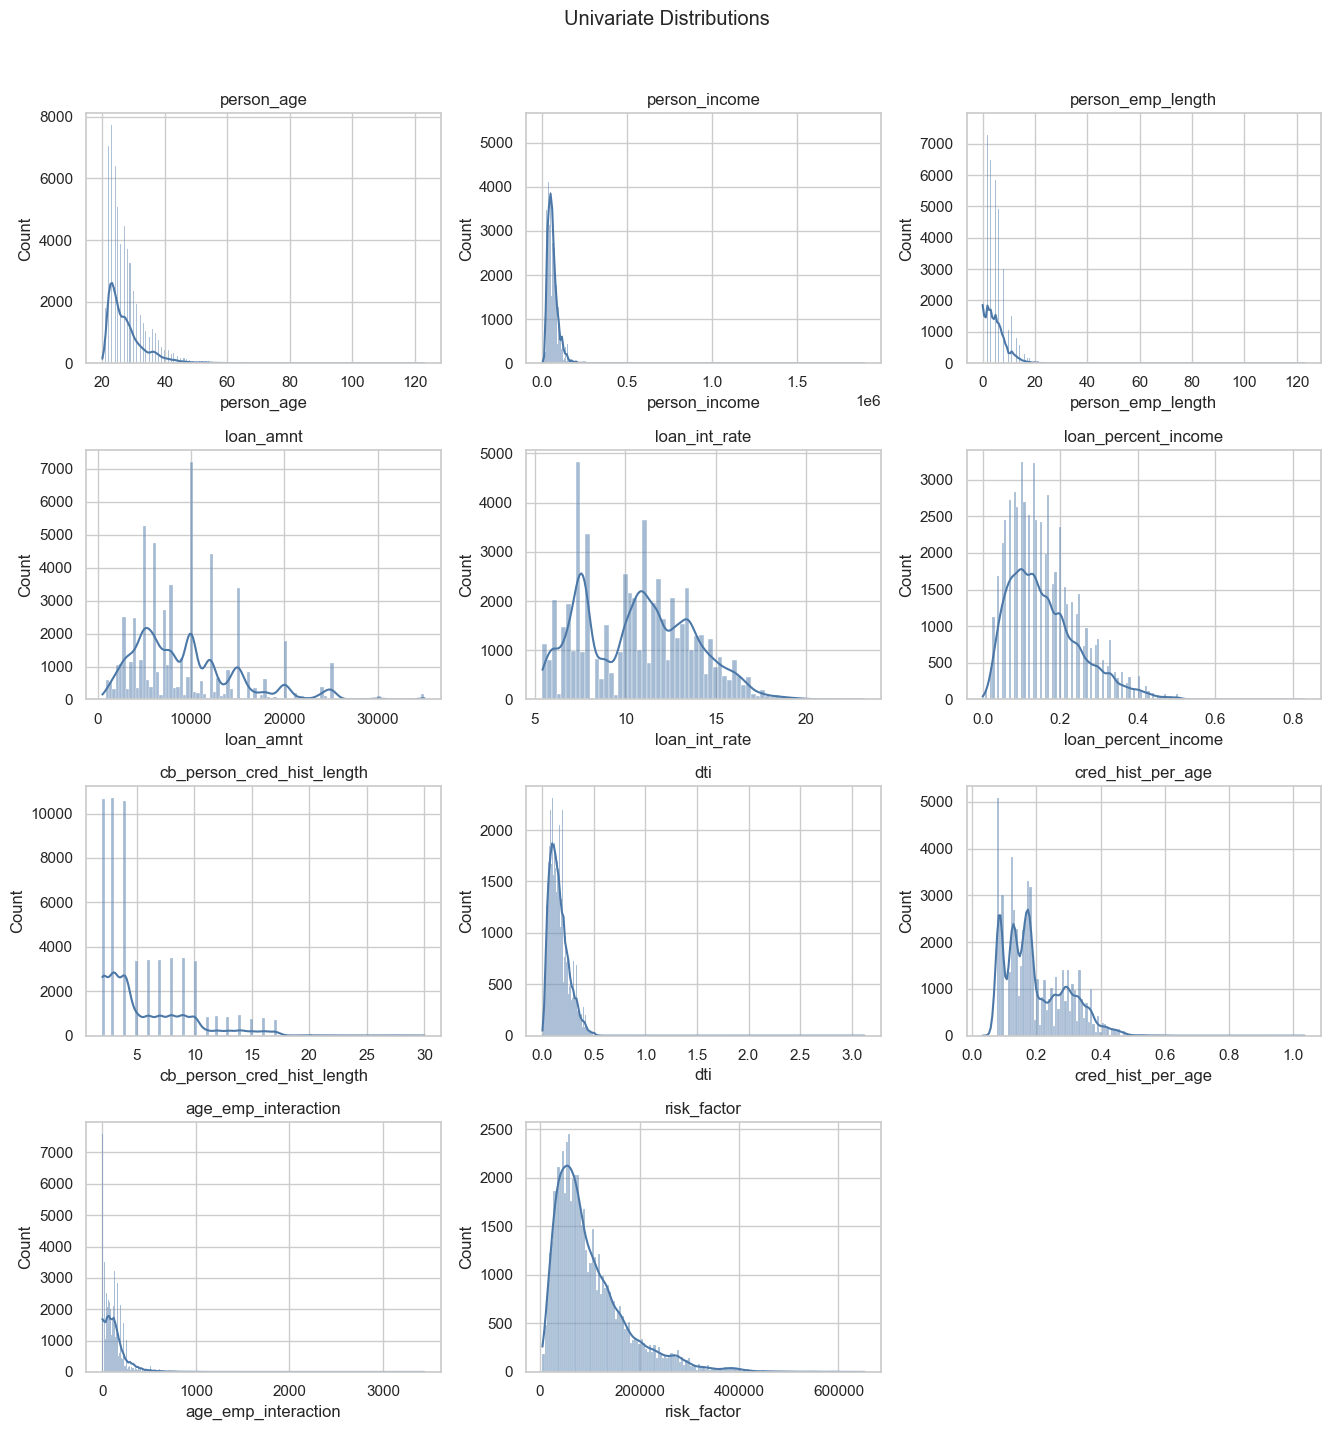

In [7]:
key_num = [
    'person_age','person_income','person_emp_length','loan_amnt','loan_int_rate',
    'loan_percent_income','cb_person_cred_hist_length','dti','cred_hist_per_age',
    'age_emp_interaction','risk_factor'
]
key_num = [c for c in key_num if c in df.columns]
n = len(key_num)
cols = 3
rows = int(np.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*4.5, rows*3.5))
axes = axes.ravel() if n>1 else [axes]
for i, c in enumerate(key_num):
    sns.histplot(df[c].dropna(), kde=True, ax=axes[i], color='#4c78a8')
    axes[i].set_title(c)
for j in range(i+1, rows*cols):
    axes[j].axis('off')
fig.suptitle('Univariate Distributions', y=1.02)
plt.tight_layout(); plt.show()
fig.savefig(FIG_DIR / 'univariate_distributions.png', dpi=150)


## Feature vs Target
Distributions stratified by `loan_status` to see separation.

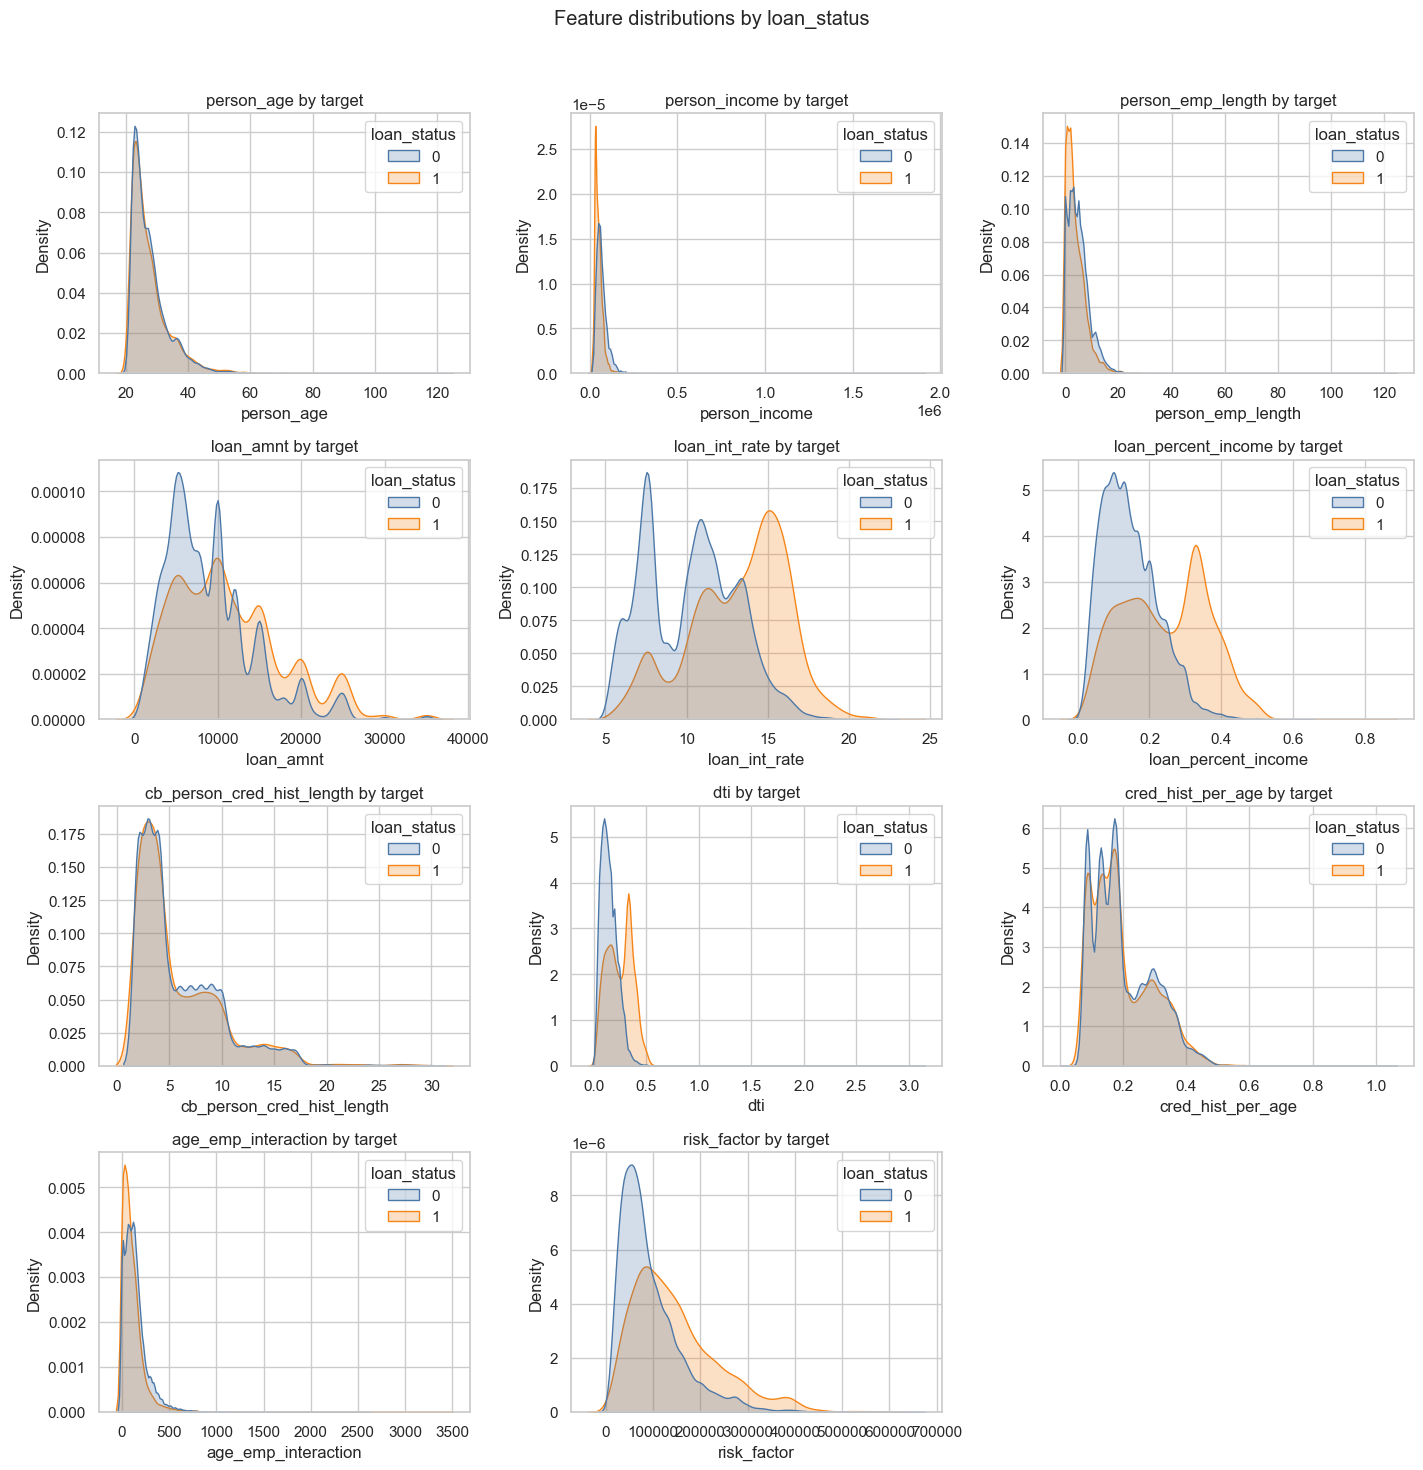

In [8]:
palette = {0:'#4c78a8', 1:'#f58518'}
n = len(key_num)
cols = 3
rows = int(np.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*4.8, rows*3.6))
axes = axes.ravel() if n>1 else [axes]
for i, c in enumerate(key_num):
    sns.kdeplot(data=df, x=c, hue=target, ax=axes[i], fill=True, common_norm=False, palette=palette)
    axes[i].set_title(f'{c} by target')
for j in range(i+1, rows*cols):
    axes[j].axis('off')
fig.suptitle('Feature distributions by loan_status', y=1.02)
plt.tight_layout(); plt.show()
fig.savefig(FIG_DIR / 'feature_vs_target_kde.png', dpi=150)


## Per-Feature vs Target (One by One)
For reporting clarity, generate one clean figure per feature showing distribution by `loan_status`. Each figure is also saved under `reports/figures` as `feature_vs_target_<feature>.png`.

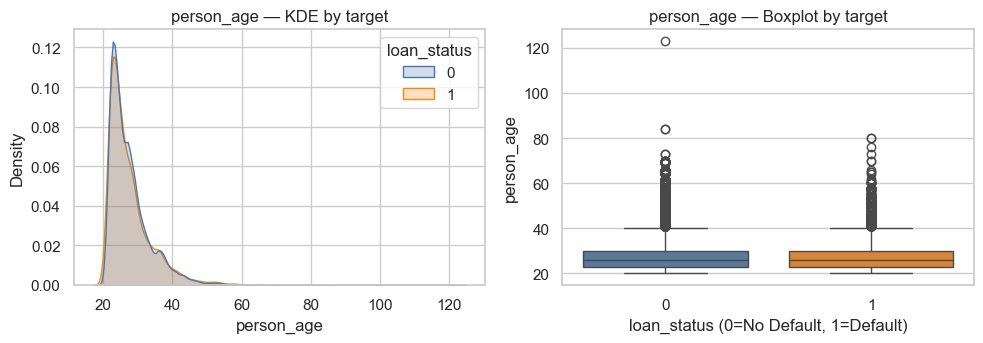

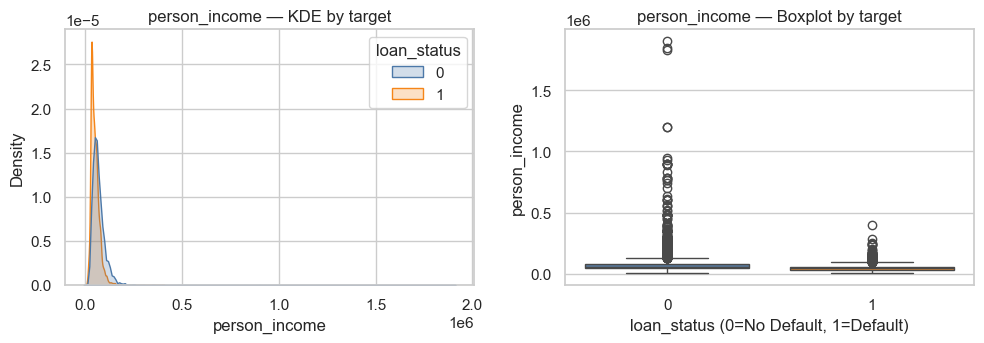

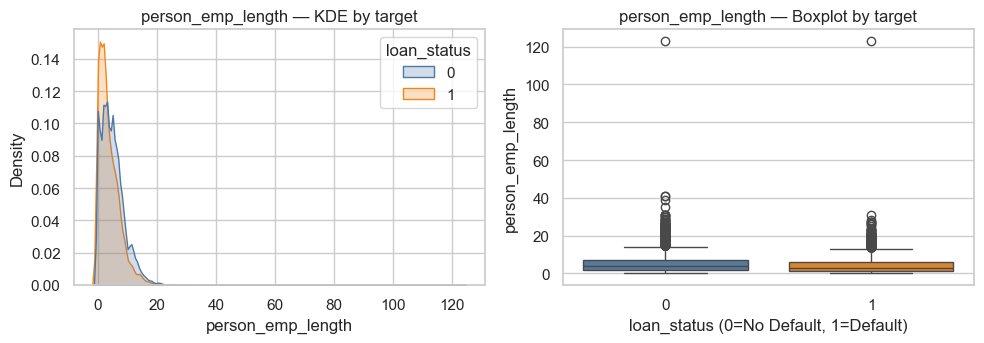

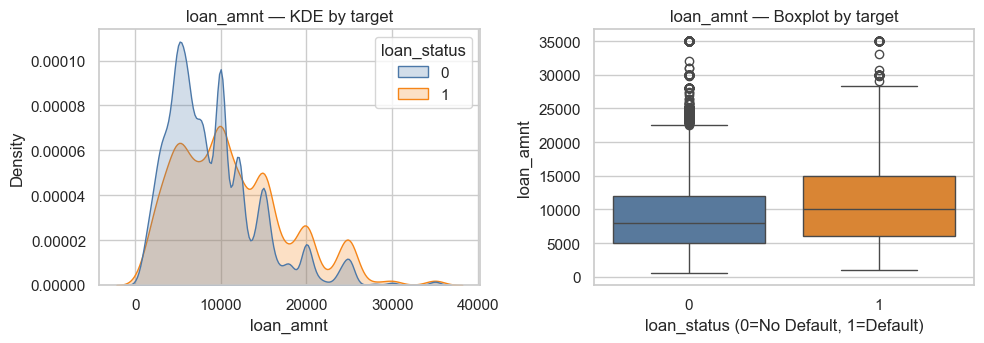

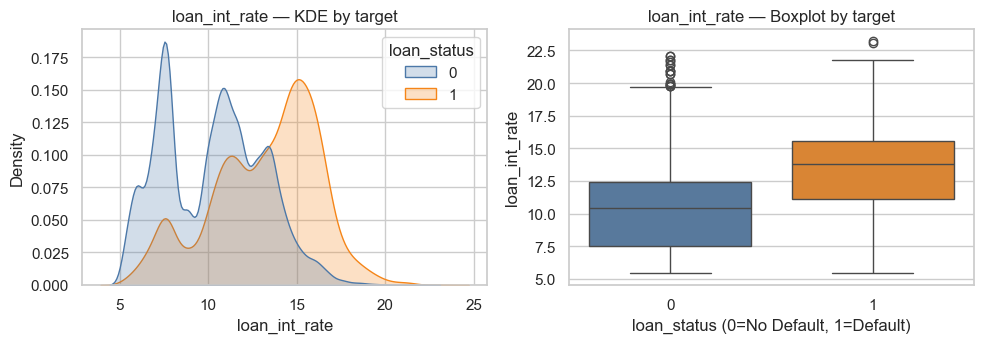

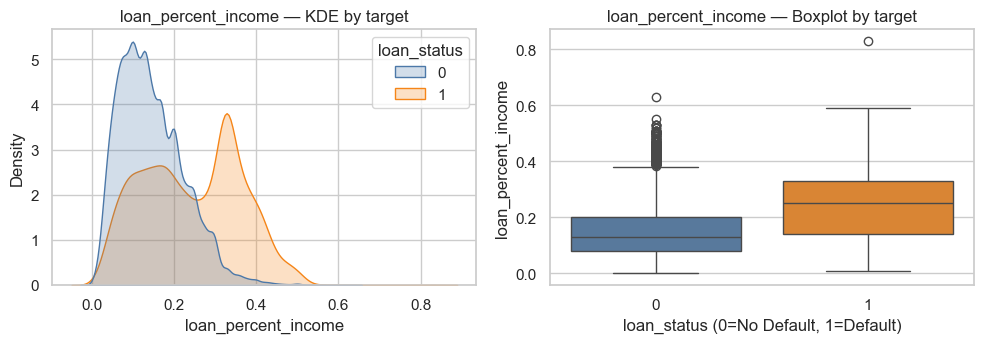

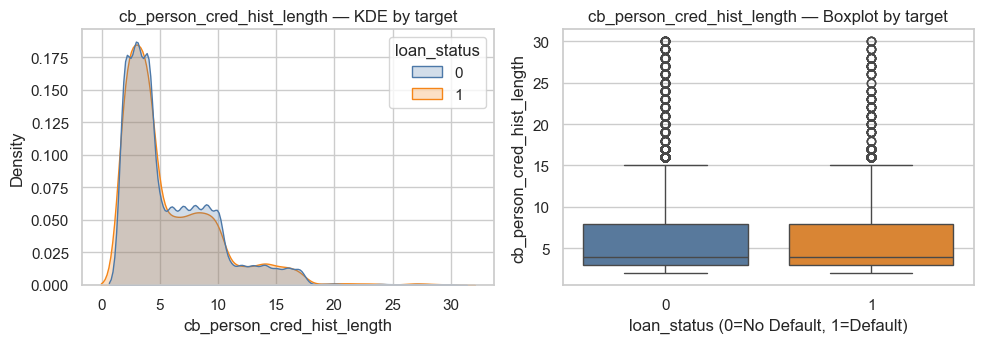

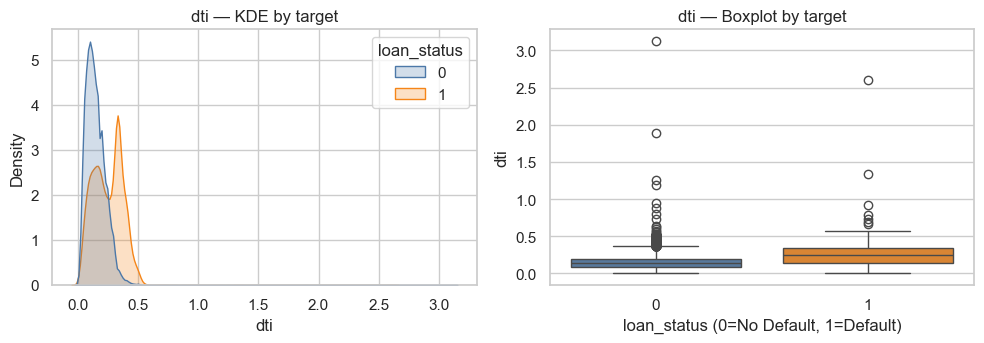

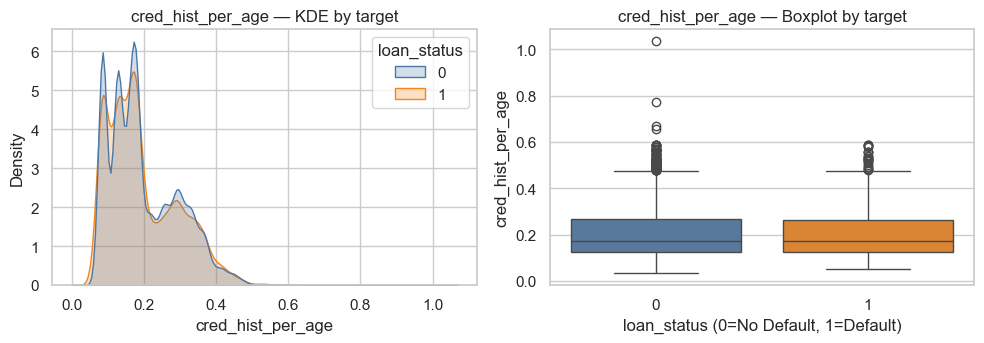

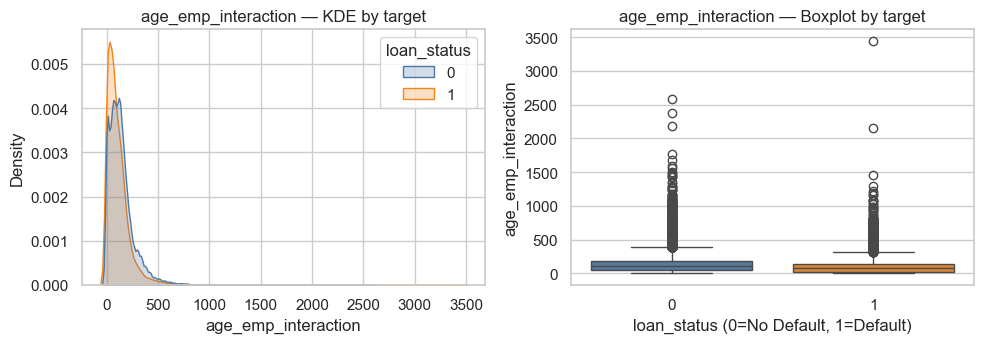

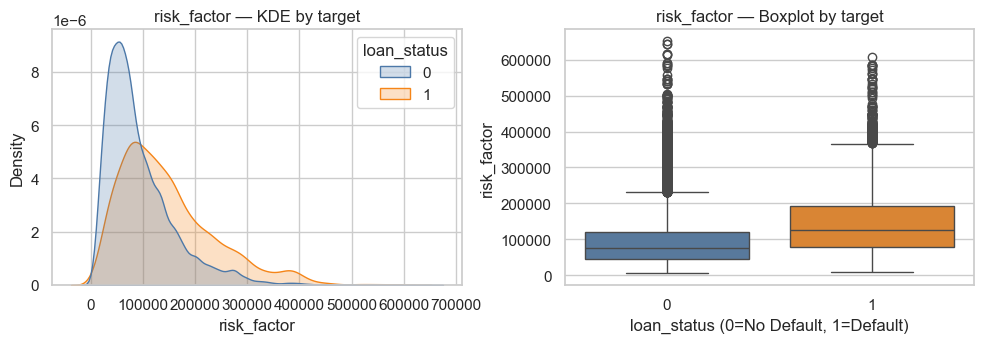

In [ ]:
palette = {0:'#4c78a8', 1:'#f58518'}
for c in key_num:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3.6))
    # KDE overlay
    sns.kdeplot(data=df, x=c, hue=target, fill=True, common_norm=False, palette=palette, ax=axes[0])
    axes[0].set_title(f'{c} — KDE by target')
    # Boxplot
    sns.boxplot(data=df, x=target, y=c, palette=[palette[0], palette[1]], ax=axes[1])
    axes[1].set_title(f'{c} — Boxplot by target')
    axes[1].set_xlabel('loan_status (0=No Default, 1=Default)')
    plt.tight_layout()
    out_path = FIG_DIR / f'feature_vs_target_{c}.png'
    fig.savefig(out_path, dpi=150)
    plt.show()


## Categorical Breakdown
Default rates by key categorical features.

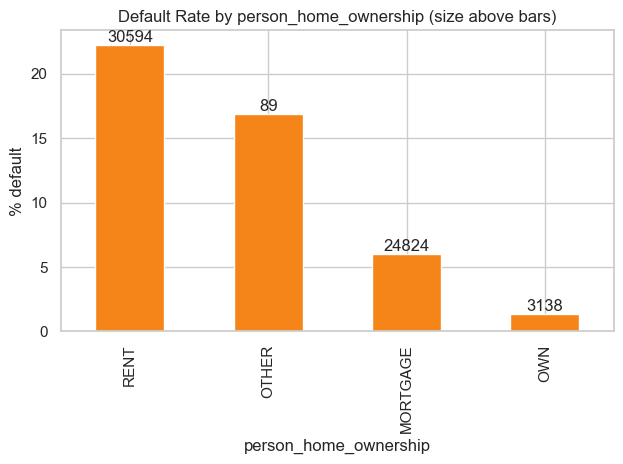

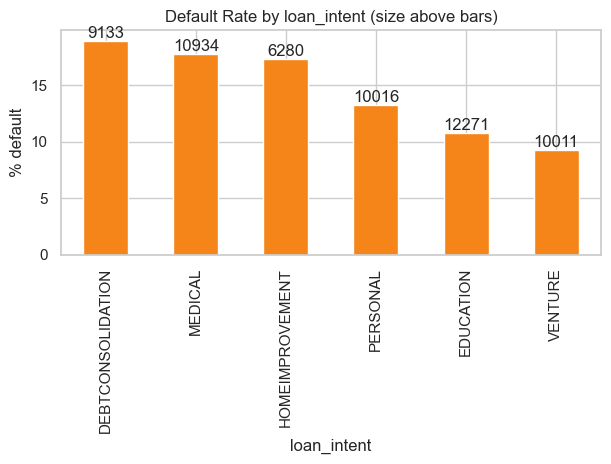

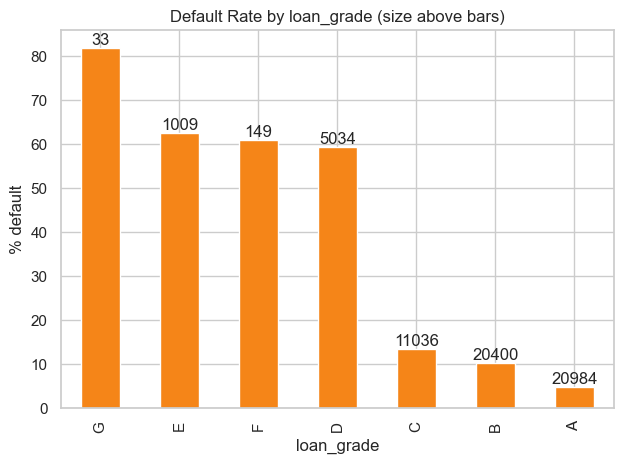

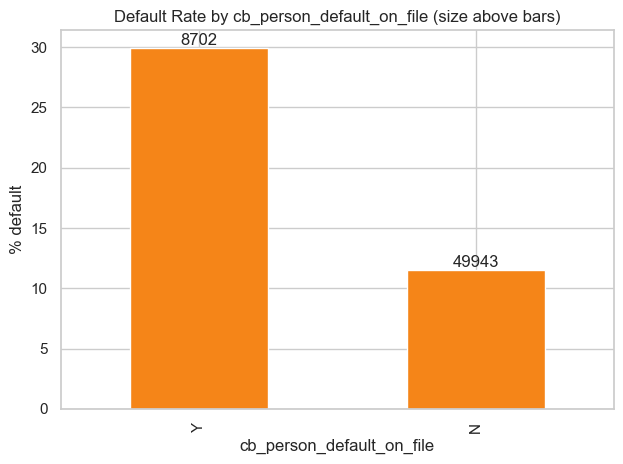

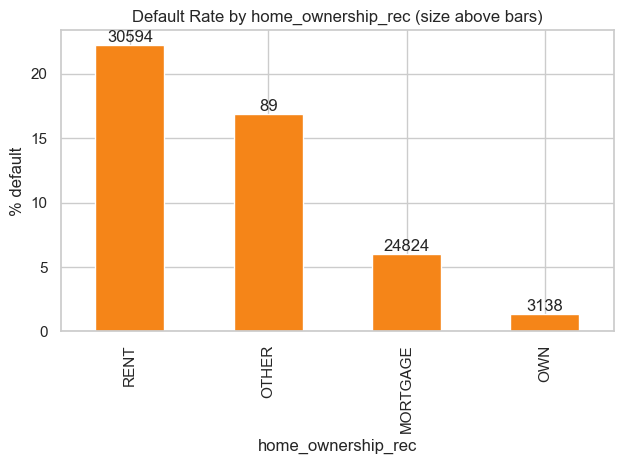

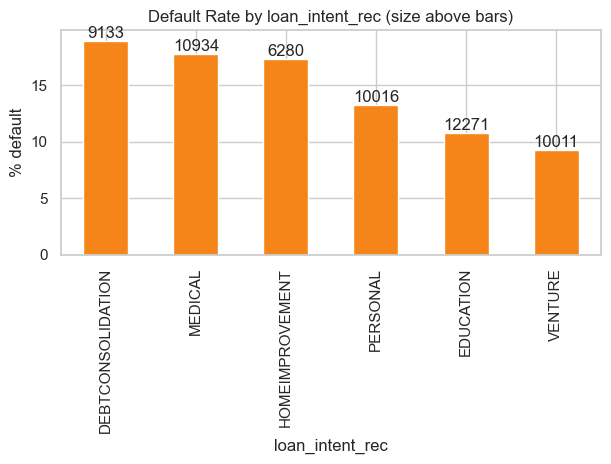

In [9]:
cats = []
for c in ['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file',
          'home_ownership_rec','loan_intent_rec']:
    if c in df.columns:
        cats.append(c)

def rate_plot(feature):
    tmp = (df.groupby(feature)[target]
            .agg(['mean','count'])
            .sort_values('mean', ascending=False))
    ax = tmp['mean'].mul(100).plot(kind='bar', color='#f58518')
    ax.set_title(f'Default Rate by {feature} (size above bars)')
    ax.set_ylabel('% default')
    for i, (idx, row) in enumerate(tmp.iterrows()):
        ax.annotate(int(row['count']), (i, row['mean']*100), ha='center', va='bottom')
    plt.tight_layout(); plt.show()

for c in cats:
    rate_plot(c)


## Notes & Next Steps
- All engineered features used in modeling are included here (e.g., `dti`, `cred_hist_per_age`, `age_emp_interaction`, `risk_factor`, boolean flags, and encodings).
- Consider trying binning for skewed variables (e.g., `person_income`, `loan_amnt`) and checking monotonicity vs target.
- You can export figures from `reports/figures` for your report or model card.

## Correlations
- Heatmap of numeric correlations
- Top correlations with target

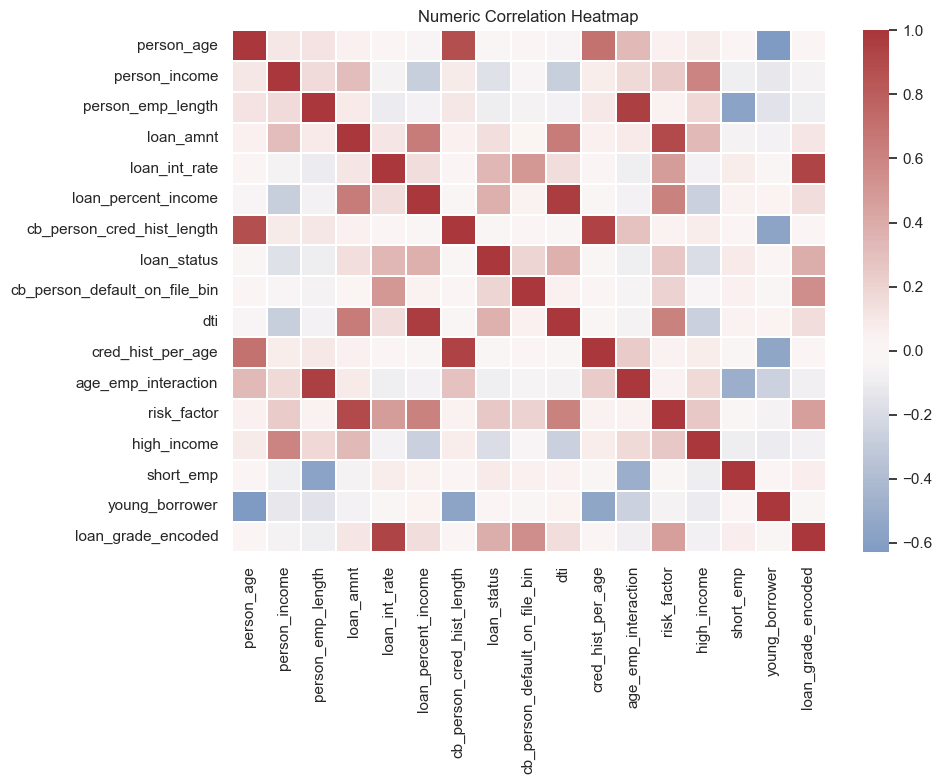

,corr_with_target
loan_grade_encoded,0.385908
loan_percent_income,0.378280
dti,0.375608
loan_int_rate,0.338948
risk_factor,0.253473
high_income,-0.189853
cb_person_default_on_file_bin,0.186962
person_income,-0.169956
loan_amnt,0.144982
person_emp_length,-0.100428


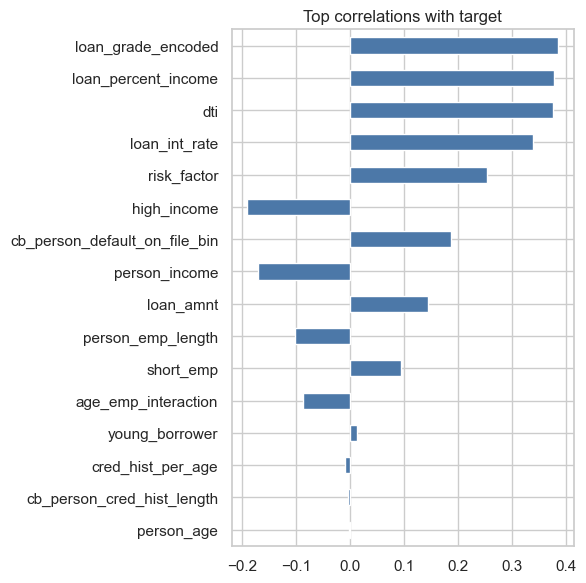

In [10]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='vlag', center=0, linewidths=0.1)
plt.title('Numeric Correlation Heatmap')
plt.tight_layout(); plt.show()

if target in corr.columns:
    tgt_corr = corr[target].drop(labels=[target]).sort_values(key=np.abs, ascending=False)
    display(tgt_corr.to_frame('corr_with_target').head(20))
    ax = tgt_corr.head(20).iloc[::-1].plot(kind='barh', color='#4c78a8', figsize=(6,6))
    ax.set_title('Top correlations with target')
    plt.tight_layout(); plt.show()
